## Imports

In [345]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error
import xgboost as xgb

In [346]:
df = pd.read_csv('train.csv')
df.dropna(subset=['value_eur'], inplace=True)

In [347]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15333 entries, 0 to 15390
Data columns (total 76 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Unnamed: 0                   15333 non-null  int64  
 1   id                           15333 non-null  int64  
 2   short_name                   15333 non-null  object 
 3   long_name                    15333 non-null  object 
 4   player_positions             15333 non-null  object 
 5   overall                      15333 non-null  int64  
 6   potential                    15333 non-null  int64  
 7   value_eur                    15333 non-null  float64
 8   wage_eur                     15333 non-null  float64
 9   age                          15333 non-null  int64  
 10  dob                          15333 non-null  object 
 11  height_cm                    15333 non-null  int64  
 12  weight_kg                    15333 non-null  int64  
 13  club_team_id         

## Drop irrelevant columns

In [348]:
cols_to_drop = ['Unnamed: 0', 'id', 'short_name', "long_name", "dob", "club_jersey_number", "nation_jersey_number", "club_name", "club_loaned_from", "nation_position", "player_traits", "player_tags", "nationality_name"]

df.drop(columns=cols_to_drop, inplace=True, errors='ignore')

## Contract-related variable manipulation

In [349]:
start_date = float(2021) # year when dataset was recorded 
df["years_left_contract"] = df["club_contract_valid_until"] - start_date

df['club_joined'] = pd.to_datetime(df['club_joined'], format='%Y-%m-%d')
df["years_in_club"] = start_date - df["club_joined"].dt.year

In [350]:
df.drop(columns=["club_contract_valid_until", "club_joined"], inplace=True, errors='ignore')

## Work rate split

In [351]:
df[["work_attack", "work_defense"]] = df["work_rate"].str.split("/", expand=True)
maps = {"Low": 1, "Medium": 2, "High": 3}
df["work_attack"] = df["work_attack"].map(maps)
df["work_defense"] = df["work_defense"].map(maps)

In [352]:
df["primary_position"] = df["player_positions"].str.split(",", expand=True)[0]

## Grouping Technical Attributes

In [353]:
#Attacking attributes score
df["attacking_score"] = df[[
    "attacking_crossing",
    "attacking_finishing",
    "attacking_heading_accuracy",
    "attacking_short_passing",
    "attacking_volleys"
]].mean(axis=1)

In [354]:
#Skills attributes score
df["skills_score"] = df[[
    "skill_dribbling",
    "skill_curve",
    "skill_fk_accuracy",
    "skill_long_passing",
    "skill_ball_control"
]].mean(axis=1)

In [355]:
# Movement attributes score
df["movement_score"] = df[[
    "movement_acceleration",
    "movement_sprint_speed",
    "movement_agility",
    "movement_reactions",
    "movement_balance"
]].mean(axis=1)

In [356]:
# Power attributes score
df["power_score"] = df[[
    "power_shot_power",
    "power_jumping",
    "power_stamina",
    "power_strength",
    "power_long_shots"
]].mean(axis=1)

In [357]:
# Mentality attributes score
df["mentality_score"] = df[[
    "mentality_aggression",
    "mentality_interceptions",
    "mentality_positioning",
    "mentality_vision",
    "mentality_penalties",
    "mentality_composure"
]].mean(axis=1)

In [358]:
# Defending technical attributes score
df["defending_technical_score"] = df[[
    "defending_marking_awareness",
    "defending_standing_tackle",
    "defending_sliding_tackle"
]].mean(axis=1)

## Starter bool

In [359]:
df["is_starter"] = (~df["club_position"].isin(["SUB", "RES"])).astype(int)

## Multipositional bool

In [360]:
df["multiple_positions"] = df["player_positions"].str.split(",").apply(lambda x: len(x) > 1).astype(int)

## Handle Missing Data

In [361]:
null_columns = df.columns[df.isnull().any()]
print(null_columns)

Index(['release_clause_eur', 'pace', 'shooting', 'passing', 'dribbling',
       'defending', 'physic', 'goalkeeping_speed', 'years_in_club'],
      dtype='object')


In [362]:
df["years_in_club"] = df['years_in_club'].fillna(df['years_in_club'].mean())
df['release_clause_eur'] = df['release_clause_eur'].fillna(df['release_clause_eur'].median())
df['pace'] = df['pace'].fillna(0)
df['shooting'] = df['shooting'].fillna(0)
df['passing'] = df['passing'].fillna(0)
df['dribbling'] = df['dribbling'].fillna(0)
df['defending'] = df['defending'].fillna(0)
df['physic'] = df['physic'].fillna(0)
df['goalkeeping_speed'] = df['goalkeeping_speed'].fillna(0)

In [363]:
cat_cols = df.select_dtypes(include=['object']).columns

for col in cat_cols:
    df[col] = df[col].astype('category')

In [364]:
df["overall_potential"] = df["overall"] * df["potential"]

## Median-encoding for club and league

### Train-test split to avoid data leakage

In [365]:
y = df["value_eur"]

X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.2, random_state=42)

In [366]:
median_values_by_club = X_train.groupby("club_team_id")["value_eur"].median().to_dict()
median_league_value = X_train.groupby("league_name", observed=True)["value_eur"].median().to_dict()

In [367]:
X_train['median_club_value'] = X_train['club_team_id'].map(median_values_by_club)
X_test['median_club_value'] = X_test['club_team_id'].map(median_values_by_club)

X_train['median_league_value'] = X_train['league_name'].map(median_league_value)
X_test['median_league_value'] = X_test['league_name'].map(median_league_value)

In [368]:
# Calculate the mean target value for each unique value in 'club_position'
club_position_target_mean = X_train.groupby('club_position')['value_eur'].mean()

# Map the mean target values back to the 'club_position' column
X_train['club_position_encoded'] = X_train['club_position'].map(club_position_target_mean)
X_test['club_position_encoded'] = X_test['club_position'].map(club_position_target_mean)

/var/folders/5d/1zskmzgj1f9c1q3hfsv9d8p00000gn/T/ipykernel_60839/3433694786.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  club_position_target_mean = X_train.groupby('club_position')['value_eur'].mean()


In [369]:
primary_position_target_mean = X_train.groupby('primary_position')['value_eur'].mean()
X_train['primary_position_encoded'] = X_train['primary_position'].map(primary_position_target_mean)
X_test['primary_position_encoded'] = X_test['primary_position'].map(primary_position_target_mean)
X_train.drop(columns=["club_position", "primary_position"], inplace=True)
X_test.drop(columns=["club_position", "primary_position"], inplace=True)

/var/folders/5d/1zskmzgj1f9c1q3hfsv9d8p00000gn/T/ipykernel_60839/4162679358.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  primary_position_target_mean = X_train.groupby('primary_position')['value_eur'].mean()


In [370]:
X_train.drop(columns=["value_eur"], inplace=True)
X_test.drop(columns=["value_eur"], inplace=True)

X_train.drop(columns=["player_positions", "league_name"], inplace=True)
X_test.drop(columns=["player_positions", "league_name"], inplace=True)

X_train.drop(columns=["club_team_id", "nationality_id"], inplace=True)
X_test.drop(columns=["club_team_id", "nationality_id"], inplace=True)

In [371]:
# Create DMatrix for training and testing
dtrain = xgb.DMatrix(X_train, label=y_train, enable_categorical=True)
dtest = xgb.DMatrix(X_test, label=y_test, enable_categorical=True)

# Define parameters for the XGBoost model
params = {
    'objective': 'reg:squarederror',
    'max_depth': 6,
    'learning_rate': 0.1,
    'seed': 42
}

# Train the model
num_round = 1000
model = xgb.train(params, dtrain, num_round)

# Evaluate the model
train_preds = model.predict(dtrain)
test_preds = model.predict(dtest)

train_rmse = root_mean_squared_error(y_train, train_preds)
test_rmse = root_mean_squared_error(y_test, test_preds)

print(f"Train RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")

Train RMSE: 6993.364844116254
Test RMSE: 876520.2103379376


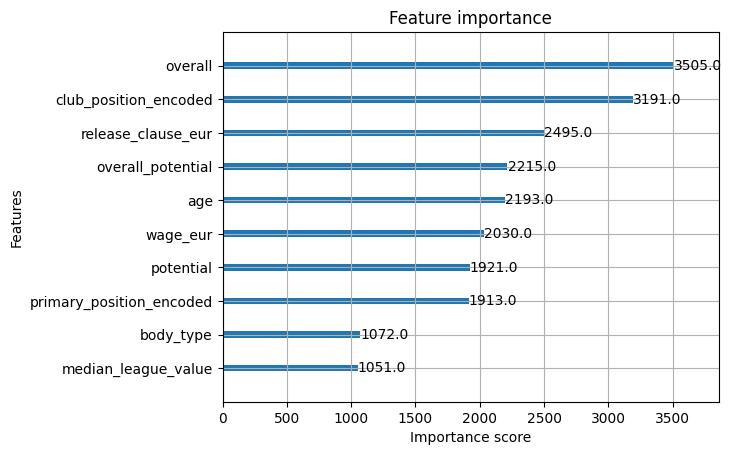

In [372]:
xgb.plot_importance(model, max_num_features=10, importance_type='weight')
plt.show()

In [373]:
# List of columns to keep
cols_to_keep = [
    "overall",
    "club_position_encoded",
    "release_clause_eur",
    "potential",
    "wage_eur",
    "age",
    "primary_position_encoded",
    "median_league_value",
    "body_type",
    "median_club_value",
    "overall_potential",
]

# Filter the dataset to keep only the specified columns
X_train = X_train[cols_to_keep]
X_test = X_test[cols_to_keep]

In [374]:
reg = xgb.XGBRegressor(
    max_depth=100,
    learning_rate=0.1,
    max_cat_to_onehot=5,
    enable_categorical=True,
)
reg.fit(X_train, y_train)

train_preds = reg.predict(X_train)
test_preds = reg.predict(X_test)

# Evaluate the model
train_rmse = root_mean_squared_error(y_train, train_preds)
test_rmse = root_mean_squared_error(y_test, test_preds)

print(f"Train RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")

Train RMSE: 6091.429519777083
Test RMSE: 959783.9029264982


In [375]:
from sklearn.preprocessing import LabelEncoder

# Create a LabelEncoder instance
le = LabelEncoder()

# Fit the LabelEncoder on the categorical columns
col = "body_type"
le.fit(X_train[col])
X_train[col] = le.transform(X_train[col])
X_test[col] = le.transform(X_test[col])

In [379]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(
    n_estimators=400,
    max_depth=75,
    random_state=42,
)

rf.fit(X_train, y_train)
train_preds = rf.predict(X_train)
test_preds = rf.predict(X_test)

# Evaluate the model
train_rmse = root_mean_squared_error(y_train, train_preds)
test_rmse = root_mean_squared_error(y_test, test_preds)
print(f"Train RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")

Train RMSE: 305297.13055571594
Test RMSE: 743484.8302976006


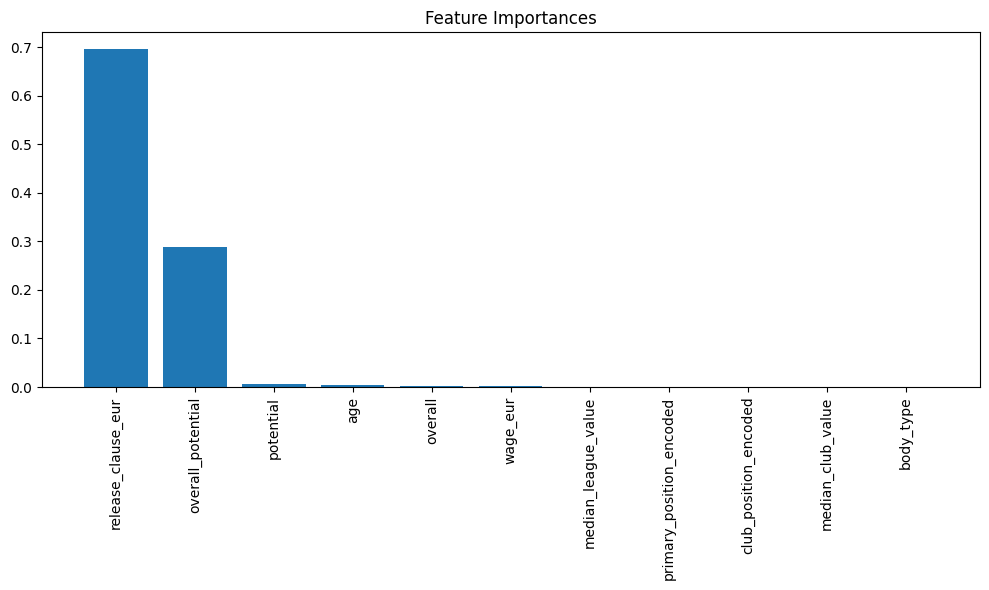

[6.95805440e-01 2.88514389e-01 5.55538112e-03 3.37822418e-03
 2.34888677e-03 1.31348748e-03 8.12811624e-04 7.58167347e-04
 6.45439060e-04 5.82987175e-04 2.84786221e-04]


In [377]:
importances = rf.feature_importances_
features = X_train.columns

# Sort the feature importances in descending order
indices = importances.argsort()[::-1]

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.bar(range(len(importances)), importances[indices], align="center")
plt.xticks(range(len(importances)), features[indices], rotation=90)
plt.tight_layout()
plt.show()
print(importances[indices])

In [203]:
cols_to_keep = ["overall", "potential", "wage_eur", "age", "median_league_value", "median_club_value"]
X_train = X_train[cols_to_keep]
X_test = X_test[cols_to_keep]

In [153]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10],
    'learning_rate': [0.2, 0.25, 0.3, 0.35, 0.4],
    'subsample': [0.5, 0.8, 1.0],
}

# Create the XGBoost regressor
xgb_reg = xgb.XGBRegressor(enable_categorical=True, random_state=42)

# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=xgb_reg,
    param_grid=param_grid,
    scoring='neg_root_mean_squared_error',
    verbose=1,
    n_jobs=-1
)

# Perform the grid search
grid_search.fit(X_train, y_train)

# Print the best parameters and the corresponding score
print("Best parameters:", grid_search.best_params_)
print("Best RMSE:", -grid_search.best_score_)

Fitting 5 folds for each of 135 candidates, totalling 675 fits
Best parameters: {'learning_rate': 0.3, 'max_depth': 3, 'subsample': 1.0}
Best RMSE: 778649.4410681797


In [154]:
# Define the parameter grid
rf_param_grid = {
    'n_estimators': [100, 500, 1000],
    'max_depth': [10, 50, 100],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Create the RandomForestRegressor
rf = RandomForestRegressor(random_state=42)

# Set up GridSearchCV
rf_grid_search = GridSearchCV(
    estimator=rf,
    param_grid=rf_param_grid,
    scoring='neg_root_mean_squared_error',
    verbose=1,
    n_jobs=-1
)

# Perform the grid search
rf_grid_search.fit(X_train, y_train)

# Print the best parameters and the corresponding score
print("Best parameters:", rf_grid_search.best_params_)
print("Best RMSE:", -rf_grid_search.best_score_)

Fitting 5 folds for each of 81 candidates, totalling 405 fits


/opt/homebrew/Caskroom/miniconda/base/envs/ML/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best parameters: {'max_depth': 50, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 1000}
Best RMSE: 826705.6031138327


In [206]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15333 entries, 0 to 15390
Data columns (total 74 columns):
 #   Column                       Non-Null Count  Dtype   
---  ------                       --------------  -----   
 0   player_positions             15333 non-null  category
 1   overall                      15333 non-null  int64   
 2   potential                    15333 non-null  int64   
 3   value_eur                    15333 non-null  float64 
 4   wage_eur                     15333 non-null  float64 
 5   age                          15333 non-null  int64   
 6   height_cm                    15333 non-null  int64   
 7   weight_kg                    15333 non-null  int64   
 8   club_team_id                 15333 non-null  float64 
 9   league_name                  15333 non-null  category
 10  league_level                 15333 non-null  float64 
 11  club_position                15333 non-null  category
 12  nationality_id               15333 non-null  int64   
 13  prefer

In [245]:
df['overall_potential'] = df['overall'] * df['potential']
df['overall_age_ratio'] = df['overall'] / df['age']
df['wage_value_ratio'] = df['wage_eur'] / df['value_eur'].clip(lower=1)

In [248]:
# Create skill aggregates with weights
attacking_cols = [col for col in df.columns if col.startswith('attacking_')]
skill_cols = [col for col in df.columns if col.startswith('skill_')]
movement_cols = [col for col in df.columns if col.startswith('movement_')]
power_cols = [col for col in df.columns if col.startswith('power_')]
mentality_cols = [col for col in df.columns if col.startswith('mentality_')]
goalkeeping_cols = [col for col in df.columns if col.startswith('goalkeeping_')]

# Weight the aggregates by the player's position
df['is_forward'] = df['club_position'].isin(['ST', 'CF', 'LW', 'RW'])
df['is_midfielder'] = df['club_position'].isin(['CAM', 'CM', 'CDM', 'LM', 'RM'])
df['is_defender'] = df['club_position'].isin(['CB', 'LB', 'RB', 'LWB', 'RWB'])
df['is_goalkeeper'] = df['club_position'] == 'GK'

# Create weighted skill scores
df['total_attacking'] = df[attacking_cols].mean(axis=1) * (df['is_forward'] * 1.5 + df['is_midfielder'] * 1.2 + 1)
df['total_skill'] = df[skill_cols].mean(axis=1) * (df['is_forward'] * 1.3 + df['is_midfielder'] * 1.4 + 1)
df['total_movement'] = df[movement_cols].mean(axis=1) * (df['is_forward'] * 1.4 + df['is_midfielder'] * 1.3 + 1)
df['total_power'] = df[power_cols].mean(axis=1) * (df['is_defender'] * 1.3 + 1)
df['total_mentality'] = df[mentality_cols].mean(axis=1)
df['total_goalkeeping'] = df[goalkeeping_cols].mean(axis=1) * (df['is_goalkeeper'] * 2 + 1)

In [249]:
# Compute the correlation matrix
correlation_matrix = df.select_dtypes(include=['float64', 'int64']).corr()

# Get the top 10 features most correlated with 'value_eur'
top_10_features = correlation_matrix['value_eur'].abs().sort_values(ascending=False).iloc[1:11]
print(top_10_features)


release_clause_eur          0.977850
wage_eur                    0.823054
overall_potential           0.638525
international_reputation    0.632083
overall                     0.558455
potential                   0.528645
movement_reactions          0.497302
mentality_composure         0.392885
mentality_vision            0.324678
power_shot_power            0.306210
Name: value_eur, dtype: float64


In [259]:
# Define the features and target variable
features = ['release_clause_eur', 'wage_eur', 'overall_potential', 'international_reputation', 'overall', 'potential']
target = 'value_eur'

X = df[features]
y = df[target]

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create DMatrix for training and testing
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Define parameters for the XGBoost model
params = {
    'objective': 'reg:squarederror',
    'max_depth': 5,
    'learning_rate': 0.1,
    'seed': 42
}

# Train the model
num_round = 500
model = xgb.train(params, dtrain, num_round)

# Make predictions
train_preds = model.predict(dtrain)
test_preds = model.predict(dtest)

# Evaluate the model
train_rmse = root_mean_squared_error(y_train, train_preds)
test_rmse = root_mean_squared_error(y_test, test_preds)

print(f"Train RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")

Train RMSE: 378468.82737049414
Test RMSE: 795827.0138352893


In [261]:
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Select non-categorical columns
non_categorical_cols = df.select_dtypes(exclude=['category', 'bool']).columns

# Define features and target
X = df[non_categorical_cols].drop(columns=['value_eur'])
y = df['value_eur']

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a pipeline with standard scaling and Lasso regression
lasso_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('lasso', Lasso(alpha=0.1, random_state=42))
])

# Fit the model
lasso_pipeline.fit(X_train, y_train)

# Evaluate the model
train_score = lasso_pipeline.score(X_train, y_train)
test_score = lasso_pipeline.score(X_test, y_test)

train_predictions = lasso_pipeline.predict(X_train)
test_predictions = lasso_pipeline.predict(X_test)

print(f"Train RMSE: {root_mean_squared_error(y_train, train_predictions)}")
print(f"Test RMSE: {root_mean_squared_error(y_test, test_predictions)}")
print(f"Train R^2: {train_score}")
print(f"Test R^2: {test_score}")


Train RMSE: 1355105.9768695033
Test RMSE: 1491782.6965045996
Train R^2: 0.9683592230983649
Test R^2: 0.956540048598875


/opt/homebrew/Caskroom/miniconda/base/envs/ML/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.126e+16, tolerance: 7.119e+13
  model = cd_fast.enet_coordinate_descent(


In [262]:
# Extract the coefficients from the Lasso model
coefficients = lasso_pipeline.named_steps['lasso'].coef_

# Print the coefficients
print("Coefficients of the Lasso model:")
print(coefficients)

Coefficients of the Lasso model:
[-3.32964170e+06 -2.82037982e+06  5.85772186e+05  1.98200535e+05
  4.01182369e+04  1.32515463e+04  5.26194156e+04  2.54818183e+04
  1.52104979e+04 -2.67211724e+03  2.13639107e+03  2.18430932e+05
  6.41580360e+06  1.38325938e+06 -4.15506849e+05  3.15697924e+04
  1.77612322e+04  4.55195315e+05  1.18351976e+05  1.69990364e+05
  4.28488074e+05  1.01814236e+05  1.61746567e+05  3.25753821e+05
 -1.00638427e+05 -8.85514819e+04 -2.33728739e+04 -1.05213160e+05
 -7.17823998e+04 -3.51138860e+05 -3.36589853e+05  1.20038163e+05
  7.41407392e+04  1.55996778e+05  8.87532868e+04 -1.66447600e+04
  9.64548057e+04  3.07548794e+04  1.03765875e+05  4.09126817e+05
  3.80445564e+05  5.14037613e+05  3.10558555e+05  3.16405051e+05
  3.27066461e+05 -9.35077984e+04 -2.97563407e+05 -1.16638133e+05
 -3.61351485e+04 -3.47544844e+03  1.10296386e+05  1.01456853e+05
  5.63215059e+03  7.67070445e+05 -1.96682321e+05 -7.88387142e+04
  6.31950342e+03  5.65622405e+03 -7.02010621e+05  1.25857

In [264]:
from sklearn.linear_model import LinearRegression

# Define the features and target variable
features = ['release_clause_eur', 'wage_eur', 'overall_potential', 'international_reputation', 'overall', 'potential']
target = 'value_eur'

X = df[features]
y = df[target]

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and fit the linear regression model
linear_reg = LinearRegression()
linear_reg.fit(X_train, y_train)

# Make predictions
train_predictions = linear_reg.predict(X_train)
test_predictions = linear_reg.predict(X_test)

# Evaluate the model
train_rmse = root_mean_squared_error(y_train, train_predictions)
test_rmse = root_mean_squared_error(y_test, test_predictions)

print(f"Train RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")

Train RMSE: 1385480.681982742
Test RMSE: 1526993.1261847601


In [277]:
df["potential_left"] = df["potential"] - df["overall"].clip(lower=0)

In [278]:
# Compute the correlation matrix
correlation_matrix = df.select_dtypes(include=['float64', 'int64']).corr()

# Get the top 10 features most correlated with 'value_eur'
top_10_features = correlation_matrix['value_eur'].abs().sort_values(ascending=False).iloc[:11]
print(top_10_features)


value_eur                   1.000000
release_clause_eur          0.977850
wage_eur                    0.823054
overall_potential           0.638525
international_reputation    0.632083
overall                     0.558455
potential                   0.528645
movement_reactions          0.497302
mentality_composure         0.392885
mentality_vision            0.324678
power_shot_power            0.306210
Name: value_eur, dtype: float64


In [268]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15333 entries, 0 to 15390
Data columns (total 88 columns):
 #   Column                       Non-Null Count  Dtype   
---  ------                       --------------  -----   
 0   player_positions             15333 non-null  category
 1   overall                      15333 non-null  int64   
 2   potential                    15333 non-null  int64   
 3   value_eur                    15333 non-null  float64 
 4   wage_eur                     15333 non-null  float64 
 5   age                          15333 non-null  int64   
 6   height_cm                    15333 non-null  int64   
 7   weight_kg                    15333 non-null  int64   
 8   club_team_id                 15333 non-null  float64 
 9   league_name                  15333 non-null  category
 10  league_level                 15333 non-null  float64 
 11  club_position                15333 non-null  category
 12  nationality_id               15333 non-null  int64   
 13  prefer